# Basic ML pipeline with sklean
In this notebook I will cover a basic machine learning pipeline using the sklearn library. For today we will use a dataset of wine https://archive-beta.ics.uci.edu/ml/datasets/Wine. The goal is to use chemical composition of wine determine their origin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Get the data

In [2]:
def get_wine_data():
    ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
    ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names

In [3]:
get_wine_data()

--2021-10-12 13:26:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0s      

2021-10-12 13:26:26 (34.5 MB/s) - ‘wine.data’ saved [10782/10782]

--2021-10-12 13:26:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3036 (3.0K) [application/x-httpd-php]
Saving to: ‘wine.names’

wine.names          100%[===================>]   2.96K  --.-KB/s    in 0s      

2021-10-12 13:26:26

In [27]:
#! cat wine.names

In [4]:
! tail wine.data

3,13.58,2.58,2.69,24.5,105,1.55,.84,.39,1.54,8.66,.74,1.8,750
3,13.4,4.6,2.86,25,112,1.98,.96,.27,1.11,8.5,.67,1.92,630
3,12.2,3.03,2.32,19,96,1.25,.49,.4,.73,5.5,.66,1.83,510
3,12.77,2.39,2.28,19.5,86,1.39,.51,.48,.64,9.899999,.57,1.63,470
3,14.16,2.51,2.48,20,91,1.68,.7,.44,1.24,9.7,.62,1.71,660
3,13.71,5.65,2.45,20.5,95,1.68,.61,.52,1.06,7.7,.64,1.74,740
3,13.4,3.91,2.48,23,102,1.8,.75,.43,1.41,7.3,.7,1.56,750
3,13.27,4.28,2.26,20,120,1.59,.69,.43,1.35,10.2,.59,1.56,835
3,13.17,2.59,2.37,20,120,1.65,.68,.53,1.46,9.3,.6,1.62,840
3,14.13,4.1,2.74,24.5,96,2.05,.76,.56,1.35,9.2,.61,1.6,560


In [28]:
names = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
         "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines",
         "Proline"]            

Here the column 0 is the class label (1,2 o 3 for the 3 regions), all other columns are features. The features (also called covariates or predictors) are used to differentiate the different regions. 

In [5]:
df = pd.read_csv("wine.data", header=None) # header=None because the csv has no header
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# look are basic stats
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [7]:
# this first column is the label
df.iloc[:,0].value_counts()

2    71
1    59
3    48
Name: 0, dtype: int64

## Make a train / validation/ test split
The train set is used to train the data. The validation set is used to find model hyperparameters (more on this later). The test set is used to estimate the actual error/performance of the model. The goal of machine learning is to **generalize** - that is, to perform well on previously **unseen** data. The model is going to have a smaller error on the data that was used for training than on unseen data. 

Since, I am not planning to find any hyperparameters, I will split in train / test. 

In [8]:
df.shape

(178, 14)

In [9]:
Y = df.iloc[:,0].values
X = df.iloc[:,1:].values

In [10]:
X.shape

(178, 13)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [12]:
x_train.shape, x_test.shape

((142, 13), (36, 13))

In [13]:
pd.Series(y_train).value_counts()/142

2    0.401408
1    0.345070
3    0.253521
dtype: float64

In [14]:
pd.Series(y_test).value_counts()/36

2    0.388889
3    0.333333
1    0.277778
dtype: float64

In [15]:
# we can split the daya in a stratified fashion, using this as the class labels 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [16]:
pd.Series(y_train).value_counts()/142

2    0.401408
1    0.330986
3    0.267606
dtype: float64

In [17]:
pd.Series(y_test).value_counts()/36

2    0.388889
1    0.333333
3    0.277778
dtype: float64

## Look at basic plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb19b806910>,
      dtype=object)

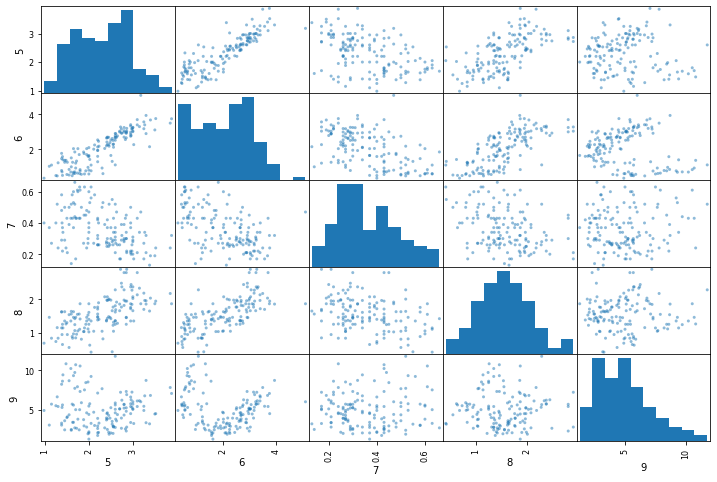

In [18]:
df_train = pd.DataFrame(x_train)
pd.plotting.scatter_matrix(df_train.iloc[:,5:10], figsize=(12,8))

In [37]:
def get_2_var_plots(x_train, y_train, names, var_1, var_2):
    x1 = x_train[:, var_1]
    x2 = x_train[:, var_2]
    plt.scatter(x1, x2, c=y_train)
    plt.xlabel(names[var_1])
    plt.ylabel(names[var_2])

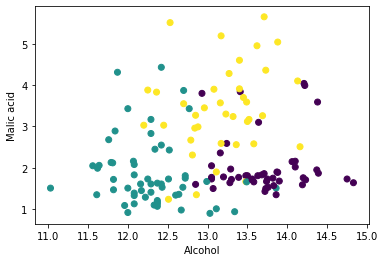

In [38]:
get_2_var_plots(x_train, y_train, names, 0, 1)

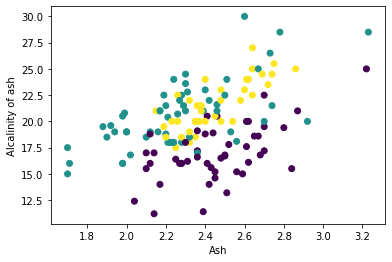

In [34]:
get_2_var_plots(x_train, y_train, names, 2, 3)

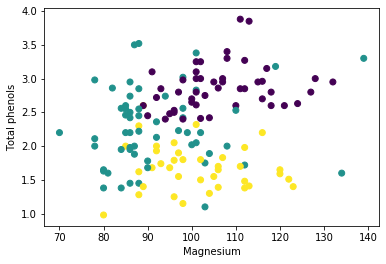

In [39]:
get_2_var_plots(x_train, y_train, names, 4, 5)

## Standarize your data
We will be fitting a linear model. In this case is always a good idea to standarize your data. If we want to "regularize" we have to standarize. The `StandardScaler()` will compute mean and standard deviation from the training set and apply it to the training and test sets.

If we don't scale the data sometimes the linear model doesn't converge fast enough.

In [40]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train) # computes mean and standard deviation from training data

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
scaler.mean_

array([1.30016197e+01, 2.33450704e+00, 2.38126761e+00, 1.96732394e+01,
       9.92816901e+01, 2.31042254e+00, 2.06492958e+00, 3.61056338e-01,
       1.56246479e+00, 4.96809859e+00, 9.62788732e-01, 2.63295775e+00,
       7.38901408e+02])

In [42]:
# transforms both the train and test sets
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

In [43]:
X_train.std(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [44]:
X_test.std(0) # it is not perfectly 1 because we used the std computed from training data

array([1.18154672, 1.16237041, 1.12176732, 0.90938309, 1.39496728,
       0.92128859, 0.96520418, 0.92119887, 1.47217126, 1.19924257,
       1.05517279, 0.90963313, 0.96920193])

## Fit a model

In [45]:
clf = LogisticRegression(random_state=0) # this creates a model
clf.fit(X_train, y_train)  # this fits the model to the training data

/Users/yannet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yannet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
# predicting 
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

In [47]:
y_test_hat

array([2, 1, 3, 1, 1, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 1, 1, 1, 3, 2, 3,
       2, 1, 2, 3, 1, 2, 1, 1, 3, 1, 1, 2, 3, 2])

In [48]:
# computing training and testing accuracy
accuracy_score(y_train, y_train_hat), accuracy_score(y_test, y_test_hat)

(1.0, 0.9722222222222222)

## Looking at the model
here is the documentation https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [49]:
clf.coef_ # gives you the coeficients

array([[ 1.31032134,  0.27215563,  0.75671216, -1.42156528,  0.35160531,
         0.0751459 ,  0.77658503, -0.10337822,  0.16832422, -0.07710007,
        -0.00865958,  0.9504406 ,  1.73604973],
       [-1.54665309, -0.79914916, -0.91364474,  0.69569172, -0.16117466,
         0.10049724,  0.40158458,  0.23676612,  0.01185069, -1.52705185,
         0.94668701,  0.11066567, -1.69250078],
       [ 0.4615224 ,  0.59589506,  0.41680034,  0.44973234, -0.00479522,
        -0.20082094, -1.18847092, -0.09615258, -0.20111255,  1.36097672,
        -0.93527904, -1.06791109, -0.04961704]])

In [50]:
clf.coef_.shape # notice the shape of the coeficients because we have 3 classes

(3, 13)

## Visualizing decision boundaries for two variables

In [51]:
# let's fit a model with two variables
clf = LogisticRegression(random_state=0) # this creates a model
clf.fit(X_train[:,:2], y_train) 

/Users/yannet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yannet/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(-1, 2, h), np.arange(-1, 2, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [53]:
x1 = X_train[y_train == 1, 0]

In [54]:
x1

array([ 0.97359999,  0.06211006,  0.61413917,  0.3060299 ,  2.34725382,
        0.93508633,  1.35873658,  1.55130487,  0.9607621 ,  1.15333039,
        0.38305721,  1.11481673,  0.63981494,  0.35738144,  0.06211006,
        1.0506273 ,  0.92224844,  1.12765462,  0.80670746,  0.52427396,
        0.87089689,  0.81954535,  1.76954894,  0.94792421,  1.41008812,
        0.20332681,  1.57698064,  0.71684226, -0.19464767,  1.78238682,
        0.06211006,  0.08778583,  0.25467835, -0.09194458,  0.37021933,
        1.5256291 ,  1.41008812,  1.75671105,  0.49859819,  1.56414276,
        0.74251803,  1.06346519,  1.10197885,  2.24455073,  0.90941055,
        0.71684226,  1.53846698])

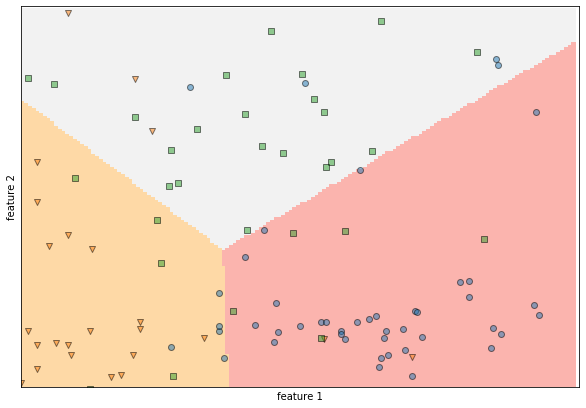

In [55]:
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 7))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel1, shading='auto')

# Plot also the training points
markers = ["o", "v", "s"]
for l in [1,2,3]:
    x1 = X_train[y_train == l, 0]
    x2 = X_train[y_train == l, 1]
    plt.scatter(x1, x2, marker=markers[l-1], edgecolor="black", alpha=.5)
plt.xlabel('feature 1')
plt.ylabel('feature 2')

plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.xticks(())
plt.yticks(())

plt.show()

## In-class Lab
1. Fit a random forest with 10 trees to the wine dataset. What test accuracy do you get?
2. Get the Iris dataset from https://archive.ics.uci.edu/ml/datasets/iris or from sklean
3. Split data into: train/ test
4. Apply standard scaling
5. Fit a logistic regression model
6. Compute train and test accuracy
7. Visualize the decision boundary on a model for two variables
8. Read the sklearn documentation and figure out how to predict probabilities instead of predicting a class for every observation